# I. Prepare
1. Please unzip the content in data.zip to a folder named 'data' under root folder
2. Download the .gnt files for train and test <br>
HWDB1.1trn_gnt(Train Data): http://www.nlpr.ia.ac.cn/databases/download/feature_data/HWDB1.1trn_gnt.zip <br>
HWDB1.1tst_gnt(Test Data): http://www.nlpr.ia.ac.cn/databases/download/feature_data/HWDB1.1tst_gnt.zip
3. Unzip the HWDB1.1trn_gnt.zip will get a .alz file. Unzip the content(.gnt files) in .alz file to a folder named 'HWDB1.1trn_gnt'. Move folder 'HWDB1.1trn_gnt' under the root/data/ folder.
4. Unzip the content(.gnt files) in HWDB1.1tst_gnt.zip to a folder named 'HWDB1.1tst_gnt'. Move folder 'HWDB1.1tst_gnt' under the root/data/ folder.
5. Install all required packages in your environment (keras, tensorflow, opencv, tkinter etc.), or use conda to install the packages from package-list.txt. 
6. In terminal, go to the root/data folder, run 'python gnt2image.py' or 'python3 gnt2image.py' under the data folder in terminal.
7. Then run the script.ipynb sequentially


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import os
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200

import keras
from keras.models import Model, load_model
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.callbacks import ModelCheckpoint

from dataloader import trainGenerator, validGenerator
from model_9_layer_GSLRE import build_model_GSLRE
from visualize import layer_predict, display_channel_images, plotting_curves, compare_curves, binarify_sample
from training import training_loop, evaluation
from keras.utils.vis_utils import plot_model

Using TensorFlow backend.


In [2]:
rootDir='./data/image_data'
trainDir = os.path.join(rootDir, 'train')
validDir = os.path.join(rootDir, 'test')
with open('./data/char_dict', 'rb') as handler:
    charDict = pkl.load(handler)
    
with open('./data/index_key_500.pickle', 'rb') as handler:
    index_key_500 = pkl.load(handler)

classSize = 500
batchSize = 128
val_batchSize = 128
width, height = 96, 96

# II. Data Loading

In [24]:
vg_origin = validGenerator(validDir, val_batchSize, 96, 96)
vg_binary = validGenerator(validDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 29894 images belonging to 500 classes.
Found 29894 images belonging to 500 classes.


In [21]:
tg_origin = trainGenerator(trainDir, batchSize, 96, 96)
tg_binary = trainGenerator(trainDir, val_batchSize, 96, 96, binary=True, thresh=0.99)

Found 119702 images belonging to 500 classes.
Found 119702 images belonging to 500 classes.


Data visualize and a sample of binarify


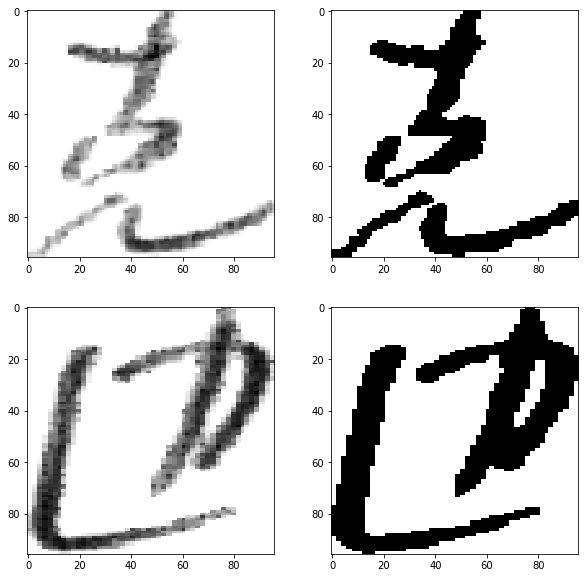

In [25]:
print('Data visualize and a sample of binarify')
tg_sample = tg_origin[0][0][0]
vg_sample = vg_origin[0][0][0]

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0, 0].imshow(tg_sample.reshape(width, height), cmap='gray')
axes[0, 1].imshow(binarify_sample(tg_sample, 0.99), cmap='gray')
axes[1, 0].imshow(vg_sample.reshape(width, height), cmap='gray')
axes[1, 1].imshow(binarify_sample(vg_sample, 0.99), cmap='gray')

# III. Training 

OR download the weights (50.6MB for each model) from: <br>
Model A trained with original images: <br>
https://drive.google.com/open?id=14gVqHhUaMtOhANS4EpymiUnhaNExPxG2
<br> Model B trained with binary images (threshold 0.99): <br>
https://drive.google.com/open?id=1TQGx8wGSg7GSXHqxAd-VpRHKMBFlVeTa
<br> And the our pickle files for histroy of training are provided on markus repo 

In [16]:
modelA = build_model_GSLRE(classSize)
modelB = build_model_GSLRE(classSize)

In [ ]:
#Model A training 
training_loop(modelA, tg_origin, vg_origin, 
              'model_origin_weights_best_epoch.hdf5', 
              'history_epoch_origin.pickle', epoch=50)
#The function will train the model with epoches in tens. 
#For example, if epoch=50 it train model 10 epoches 5 times

In [ ]:
#Model B training 
training_loop(modelB, tg_binary, vg_binary, 
              'model_b0.99_weights_best_epoch.hdf5', 
              'history_epoch_b0.99.pickle', epoch=50)
#The function will train the model with epoches in tens. 
#For example, if epoch=50 it train model 10 epoches 5 times

# IV. Evaluation

In [8]:
test_modelA = build_model_GSLRE(500)

test_modelA.load_weights('model_origin_weights_best_epoch.hdf5')

test_modelA.compile(loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy'])

In [21]:
test_loss_A, test_acc_A = test_modelA.evaluate_generator(vg_origin, verbose=1)

234/234 [==============================] - 463s 2s/step


In [22]:
print('Model A (trained with original image) has best loss {} \nwith accuracy {}'.format(test_loss_A, test_acc_A))

Model A (trained with original image) has best loss 0.16004430798742295 
with accuracy 0.9598916169791076


In [9]:
test_modelB = build_model_GSLRE(500)
test_modelB.load_weights('model_b0.99_weights_best_epoch.hdf5')

test_modelB.compile(loss='categorical_crossentropy',
        optimizer='SGD',
        metrics=['accuracy'])

In [23]:
test_loss_B, test_acc_B = test_modelB.evaluate_generator(vg_binary, verbose=1)

234/234 [==============================] - 467s 2s/step


In [25]:
print('Model B (trained with binarified image) has best loss {} \nwith accuracy {}'.format(test_loss_B, test_acc_B))

Model B (trained with binarified image) has best loss 0.18790950946898144 
with accuracy 0.9523650230257266


## Prediction on single sample

Prediction: 
 Original image: ['边', '也', '由', '山', '进'], Binary Image: ['边', '也', '由', '四', '口']


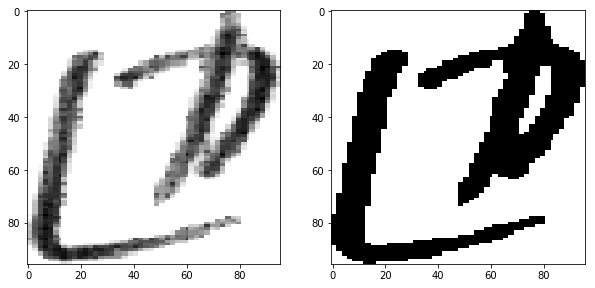

In [26]:
sampleA = vg_origin[0][0][0].reshape(1, 96, 96, 1)
sampleB = binarify_sample(sampleA.copy(), 0.99).reshape(1, 96, 96, 1)

resultA = test_modelA.predict(sampleA, batch_size=1).reshape(classSize)
resultB = test_modelB.predict(sampleB, batch_size=1).reshape(classSize)
# number of output
indexA = resultA.argsort()[-5:][::-1]
indexB = resultB.argsort()[-5:][::-1]

list_A = []
list_B = []
for i in indexA:
    list_A.append(index_key_500[i])
for i in indexB:
    list_B.append(index_key_500[i])

print("Prediction: \n Original image: {}, Binary Image: {}".format(list_A, list_B))

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(sampleA.reshape(96,96), cmap='gray')
axes[1].imshow(sampleB.reshape(96,96), cmap='gray')

## Conv Layer Output

In [11]:
# the layer names for both models are same
test_modelA.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1 (Conv2D)               (None, 96, 96, 96)        960       
_________________________________________________________________
batch_normalization_1 (Batch (None, 96, 96, 96)        384       
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 96, 96, 96)        884736    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 96)        0         
_________________________________________________________________
conv2_de1 (Conv2D)           (None, 48, 48, 41)        11849     
_________________________________________________________________
conv2_de2 (Conv2D)           (None, 48, 48, 128)       15872     
_________________________________________________________________
batch_normalization_2 (Batch (None, 48, 48, 128)       512       
__________

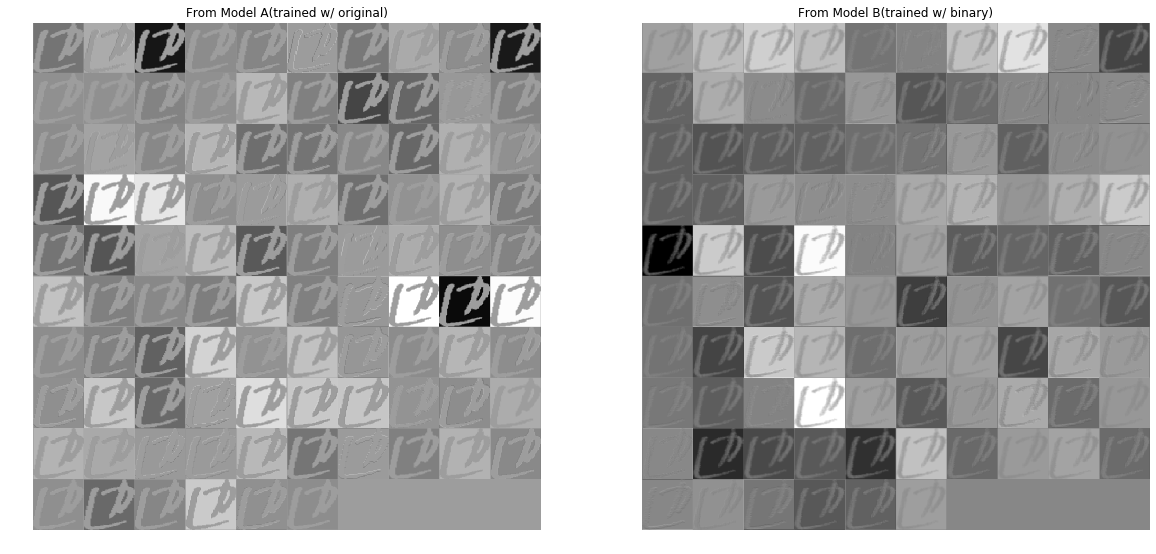

In [27]:
# for conv layers only
layer = 'conv1'
binary_model_layer = display_channel_images(test_modelA, layer, sampleA)
origin_model_layer = display_channel_images(test_modelB, layer, sampleB)

fig, axes = plt.subplots(1, 2, figsize=(20, 20))
axes[0].imshow(origin_model_layer[0], cmap='gray')
axes[0].axis('off')
axes[0].set_title('From Model A(trained w/ original)')

axes[1].imshow(binary_model_layer[0], cmap='gray')
axes[1].axis('off')
axes[1].set_title('From Model B(trained w/ binary)')

fig.savefig('{} layer output.png'.format(layer), dpi='figure')

## Plotting 

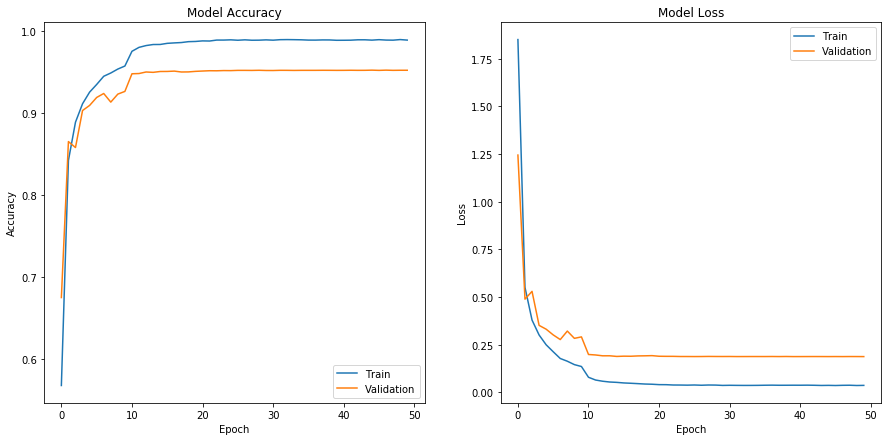

In [17]:
plotting_curves('history_epoch_b0.99.pickle', 'history_binary_model.png')

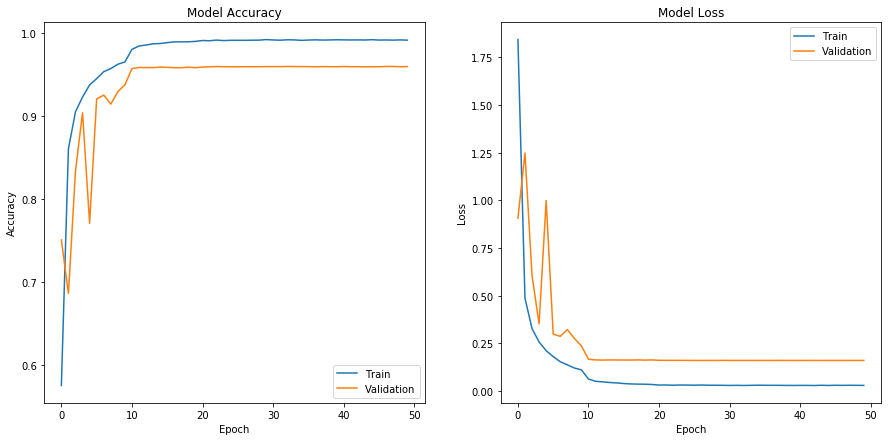

In [18]:
plotting_curves('history_epoch_origin.pickle', 'history_origin_model.png')

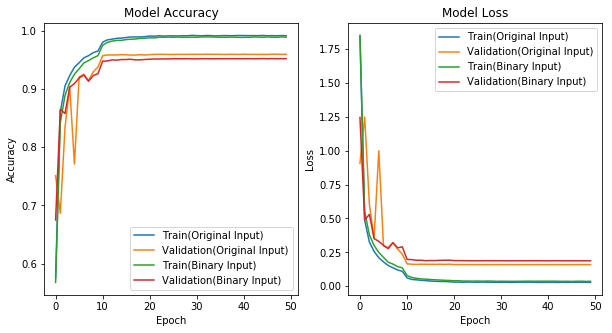

In [19]:
compare_curves('history_epoch_origin.pickle', 
               'history_epoch_b0.99.pickle', 
               'history_both_models.png')